<a href="https://colab.research.google.com/github/sstults/QuepidGPT/blob/main/QuepidGPT_gpt3_5_3cat_spearman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

In [1]:
!pip install -q openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 8.3 MB/s eta 0:00:00


# Load the instructions and the reference CSVs

In [2]:
import pandas as pd
import os

from google.colab import drive
drive.mount('/content/gdrive')

data_dir = "/content/gdrive/MyDrive/QuepidGPT/thd_files"
train_file = "train.csv"
desc_file = "product_descriptions.csv"

train_df = pd.read_csv(os.path.join(data_dir, train_file), index_col="id", encoding="latin1")
desc_df = pd.read_csv(os.path.join(data_dir, desc_file), index_col="product_uid", encoding="latin1")

Mounted at /content/gdrive


## Instructions round 1

In [3]:
instructions = """
Act as a judge determining to what extent a search result matches the search query that it is paired with. Use the following rules to judge how well each result matches the query intent. All of the items are related to home and garden products. Your job is to understand the intent and relevancy of the search query. This task is not about your opinions of the relevancy of these items.

The user provides:
- Query: This is the actual search term that a user has put into a search engine.
- Title: The title of the product that was returned for the search query.
- Description: The description of the product that was returned.

Choose Perfect Match if:
- The result matches the query intent perfectly.
- The searched product is a part of a kit or included as a part or an item in the product shown.
- The product is exactly what the customer was most likely trying to find.
- The query was for a brand and the result is made by that brand.

Choose Partially or somewhat relevant if:
- The result generally matches the query, but there is ambiguity in either search terms or product details that prevents you from choosing 'Perfect Match.'
- Actual product is the same but differs in brand, dimensions, color or specifications.
- Product specifications are not clear or product is a somewhat ambiguous synonym of the search term.
- One of the many products searched in the query are shown. (example: when searching for  washer & dryer, only washer is shown)

Choose Irrelevant: Paired with Search by Mistake if:
- The result is not at all related to the intent of the search term.
- The result is an item that is used with search term such as tool, accessory, extra part, cover or case.
- The result has a completely different meaning, even if there are words in common with the search term.
- The result is a collection of items and the search term does not appear in the set.

Do not assume you know whether the result matches the query before sufficiently examining the information provided.
Do not use only the words in the query and result to determine relevancy. This task is about intent, not word matching.

Decide how relevant each product is to the query using these ratings:
- Reply with "1" if the product is Irrelevant
- Reply with "2" if the product is Partially or somewhat relevant
- Reply with "3" if the product is a Perfect Match
"""

## Instructions round 2

In [21]:
instructions = """
Your task is to rate the relevance of a search result that is paired with a search query. You are provided with three pieces of information:

    Query: This is the actual search term that a user has put into a search engine.
    Title: The title of the product that was returned for the search query.
    Description: The description of the product that was returned.

Your job is to understand the intent of the search query and determine how well each result matches that intent. The search queries and results are all related to home and garden products. Please do not base your judgment on your personal opinions about the relevance of the items.

You should rate each result based on the following criteria:

    Perfect Match: Choose this rating if the result matches the query intent perfectly. For example, if the search query is for a specific brand or product, and the result is exactly what the user was looking for, then it is a perfect match. Also, if the searched product is part of a kit or included as a part or an item in the product shown, it is a perfect match.

    Partially or Somewhat Relevant: Choose this rating if the result generally matches the query, but there is ambiguity in either search terms or product details that prevents you from choosing a "perfect match" rating. For example, if the product specifications are not clear, or if the product is a somewhat ambiguous synonym of the search term, it is only partially or somewhat relevant.

    Irrelevant: Paired with Search by Mistake: Choose this rating if the result is not related to the intent of the search term at all. For example, if the result is an item that is used with the search term, such as a tool, accessory, extra part, cover or case, it is irrelevant. Also, if the result has a completely different meaning, even if there are words in common with the search term, it is irrelevant. If the result is a collection of items and the search term does not appear in the set, it is also irrelevant.

Please note that you should not assume you know whether the result matches the query before examining the information provided carefully. You should also avoid using only the words in the query and result to determine relevancy. This task is about intent, not word matching.

Your ratings should be as follows:

    "1" if the product is irrelevant
    "2" if the product is partially or somewhat relevant
    "3" if the product is a perfect match

Please carefully evaluate the search queries and results to provide the most accurate ratings.
"""

# Clean the raw data

In [4]:
train_df['relevance'].value_counts()

3.00    19125
2.33    16060
2.67    15202
2.00    11730
1.67     6780
1.33     3006
1.00     2105
2.50       19
2.75       11
2.25       11
1.75        9
1.50        5
1.25        4
Name: relevance, dtype: int64

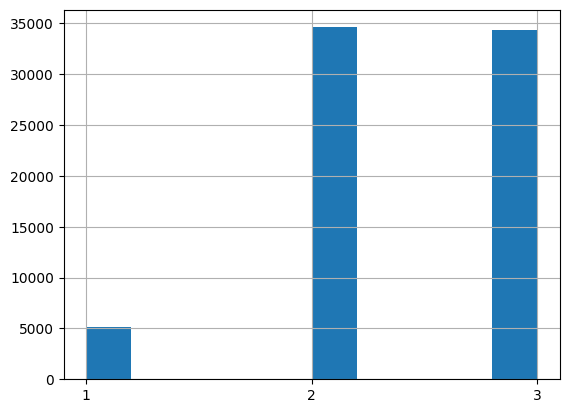

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# remove any rows that don't have a relevance score
train_df = train_df.dropna(subset=['relevance'])

train_df['relevance_rounded'] = train_df['relevance'].round().astype(int)

# create a histogram of the values in the 'value' column
train_df['relevance_rounded'].hist()

# extract the distinct values in the 'value' column
distinct_values = train_df['relevance_rounded'].unique()

# set the x-axis labels to the distinct values
plt.xticks(ticks=distinct_values)

# display the histogram
plt.show()

# Load OpenAI Key

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

import json

with open('/content/gdrive/My Drive/QuepidGPT/secrets.json') as f:
  secrets = json.load(f)

import openai
openai.organization = secrets['OPENAI_ORG']
openai.api_key = secrets['OPENAI_API_KEY']

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Define the LLM rating function

In [22]:
import re
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)

@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def get_llm_rating(row):
  query = row['search_term']
  uid = row['product_uid']
  title = row['product_title']
  description = desc_df.loc[uid]["product_description"]

  prompt = f"Query: {query}\nTitle: {title}\n Description: {description}\n"

  messages = [
      {"role": "system", "content": instructions},
      {"role": "user", "content": f"Rate the following query-result pair: {prompt}\n"}
    ]

  response = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages=messages,
      temperature=0.5
  )

  content = response['choices'][0]['message']['content']


  match = re.search(r'\d(\.\d+)?', content)

  if match:
    rating = int(match.group())
  else:
    rating = int(0)

  print(f"Query: {query}")
  print(f"Title: {title}")
  print(f"Description: {description}")
  print(f"Expected: {row['relevance_rounded']}")
  print(f"Relevance: {rating}")
  print(f"Explanation: {content}\n")

  return pd.Series([rating, content])

# Create a sample of LLM ratings

In [23]:
sample = train_df.sample(n=50)

sample[['RaterLLM', 'explanation']] = sample.apply(get_llm_rating, axis=1, result_type='expand')


Query: 8 light
Title: Lithonia Lighting 4 ft. Wraparound Fluorescent Ceiling Fixture
Description: The hinged diffuser design of the Lithonia Lighting 4 ft. Wraparound Fluorescent Ceiling Fixtures offers easy maintenance and cleaning. These fixtures feature durable plastic construction and an instant-on ballast to help prevent flickering. This fixture uses 2 (32W) T8 Bulbs (not included).Plastic constructionWhite colorEnergy-efficient fluorescent fixtureHinged diffuser design offers easy maintenance and cleaningDiffuser has side prisms to help control brightness and bottom prisms to reduce lamp imagesInstant-on ballast eliminates flickering and hummingResidential electronic ballast does not interfere with other electronic equipmentUse for residential and light commercial applicationsUL listed
Expected: 2
Relevance: 2
Explanation: Rating: 2 (Partially or Somewhat Relevant)

Explanation: The query "8 light" is not very specific and could refer to a variety of products. The result is a flu

# Examine the results

In [25]:
from scipy.stats import spearmanr

corr, pval = spearmanr(sample['relevance_rounded'], sample['RaterLLM'])

# print the results
print(f"Spearman's rank correlation coefficient: {corr:.3f}")
print(f"p-value: {pval:.5f}")

Spearman's rank correlation coefficient: 0.362
p-value: 0.00982


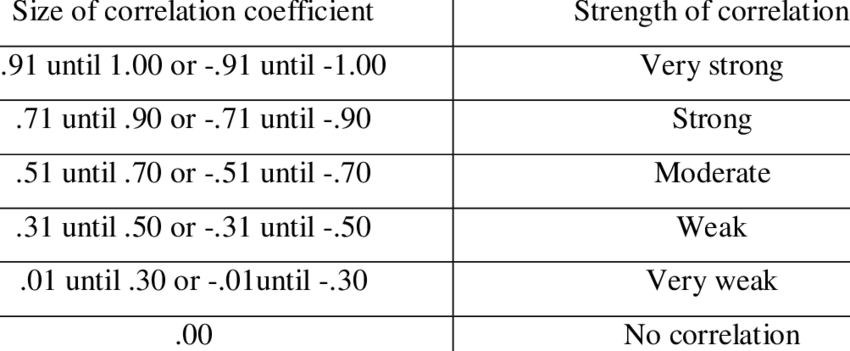

In [18]:
avg_diff = (sample['relevance_rounded'] - sample['RaterLLM']).abs().mean()
print(avg_diff)

0.4


In [26]:
# Compute the absolute difference between the two columns
abs_diff = (sample['relevance_rounded'] - sample['RaterLLM']).abs()

# Find the maximum difference
max_diff = abs_diff.max()

# Create a boolean mask for the rows with the maximum difference
max_diff_mask = (abs_diff == max_diff)

# Extract the rows with the maximum difference
max_diff_rows = sample.loc[max_diff_mask]

# Print the result
max_diff_rows

,product_uid,product_title,search_term,relevance,relevance_rounded,RaterLLM,explanation
id,,,,,,,
157609,160419,Houseworks Crates and Pallet 18 in. x 12.5 in....,video wooden crates,2.67,3,1,Rating: 1 (Irrelevant)\n\nExplanation: The sea...
158329,160856,Grip-Rite #7 x 7/16 in. Bugle Pan Head Framing...,framing wood,2.67,3,1,Rating: 1 (Irrelevant)\n\nExplanation: The pro...


# Save the results

In [20]:
from google.colab import drive
drive.mount('/content/drive')

# Then, save the DataFrame as a CSV file
sample.to_csv('/content/drive/MyDrive/quepid-gpt3-5-turbo-3cat-spearman.csv', index=False)


Mounted at /content/drive
